In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
from sklearn.cluster import OPTICS
import plotly.express as px
import plotly.graph_objects as go
pd.options.mode.chained_assignment = None  # default='warn'

# create plots folder if none
if not os.path.isdir('plots/'):
    os.mkdir('plots/')

In [2]:
# read point cloud fuse
point_cloud = pd.read_csv('data/final_project_point_cloud.fuse', 
                          delimiter = " ", header = None, 
                          names = ['latitude', 'longitude', 'altitude', 'intensity'])
trajectory = pd.read_csv('data/trajectory.fuse', 
                          delimiter = " ", header = None, 
                          names = ['latitude', 'longitude', 'altitude', 'intensity'])
point_cloud

,latitude,longitude,altitude,intensity
0,45.903883,11.028414,232.4648,10
1,45.903683,11.028221,234.4706,5
2,45.903683,11.028222,234.4459,7
3,45.903682,11.028224,234.4307,7
4,45.903681,11.028226,234.4232,7
...,...,...,...,...
430731,45.904309,11.028493,225.9179,4
430732,45.904318,11.028531,225.2816,5
430733,45.904300,11.028428,225.2848,6
430734,45.904317,11.028523,225.2883,5


### Lat/Lon/Alt to ECEF (Earth Centered, Earth Fixed)

In [3]:
def lla_to_ecef(lat, lon, alt):
    lat = np.radians(lat)
    lon = np.radians(lon)
    rad = np.float64(6378137.0)        # Radius of the Earth (in meters)
    f = np.float64(1.0 / 298.257223563)  # Flattening factor WGS84 Model
    FF     = (1.0-f)**2
    C      = 1/np.sqrt(np.cos(lat) **2 + FF * np.sin(lat) **2)
    S      = C * FF

    x = (rad * C + alt)* np.cos(lat) * np.cos(lon)
    y = (rad * C + alt)* np.cos(lat) * np.sin(lon)
    z = (rad * S + alt)* np.sin(lat)
    return x, y, z

In [4]:
# point_cloud
x, y, z = lla_to_ecef(np.array(point_cloud['latitude']), np.array(point_cloud['longitude']), 
                      np.array(point_cloud['altitude']))
point_cloud['x'] = x
point_cloud['y'] = y
point_cloud['z'] = z
point_cloud['from'] = 'PointCloud'
# camera
x, y, z = lla_to_ecef(np.array(trajectory['latitude']), np.array(trajectory['longitude']), 
                      np.array(trajectory['altitude']))
trajectory['x'] = x
trajectory['y'] = y
trajectory['z'] = z
trajectory['from'] = 'Camera'

## Point Cloud 3D Plot

The plots take lots of memory so it is not showed in this notebook.\
You can uncomment fig.show() to see the plots or open the saved plot file which is in html

In [5]:
pc_cam = point_cloud.append(trajectory, ignore_index = True)

TITLE = 'LLA Point Cloud 3D'
fig = px.scatter_3d(pc_cam, x = 'latitude', y = 'longitude', z = 'altitude', 
                                size = 'intensity', symbol = 'from', color = 'from', title = TITLE)
fig = fig.update_layout(scene = dict(zaxis = dict(nticks=4, range=[210, 235],)))
fig = fig.update_traces(marker = dict(line = dict(width = 0)))
fig.write_html(f"plots/{TITLE}.html")
del pc_cam
#fig.show()
print('To view the plot, open', os.path.join(os.getcwd(), 'plots', TITLE + '.html'))

To view the plot, open C:\Users\Gelo\Desktop\IIT\CS-513\Road Boundary Detection in Point Cloud\plots\LLA Point Cloud 3D.html


In [6]:
ecef_pc_cam = point_cloud.append(trajectory, ignore_index = True)

TITLE = 'ECEF Point Cloud 3D'
fig = px.scatter_3d(ecef_pc_cam, x = 'x', y = 'y', z = 'z', symbol = 'from', size = 'intensity', color = 'from',
                   title = TITLE)
fig = fig.update_traces(marker = dict(line = dict(width = 0)))
fig.write_html(f"plots/{TITLE}.html")
del ecef_pc_cam
#fig.show()
print('To view the plot, open', os.path.join(os.getcwd(), 'plots', TITLE + '.html'))

To view the plot, open C:\Users\Gelo\Desktop\IIT\CS-513\Road Boundary Detection in Point Cloud\plots\ECEF Point Cloud 3D.html


### Some Analysis

<AxesSubplot:>

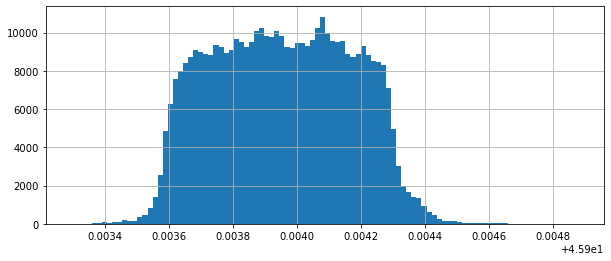

In [7]:
point_cloud.latitude.hist(bins = 100, figsize = (10, 4))

<AxesSubplot:>

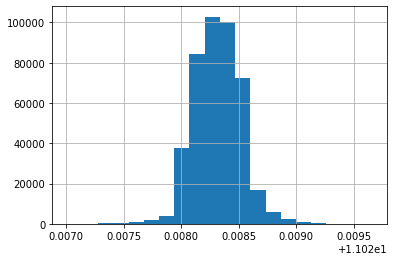

In [8]:
point_cloud.longitude.hist(bins = 20)

<AxesSubplot:>

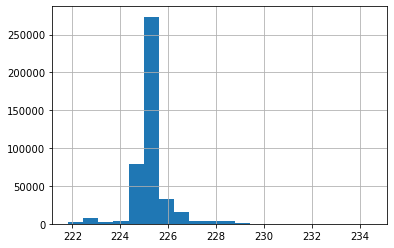

In [9]:
point_cloud.altitude.hist(bins = 20)

Can manually choose altitude and possibly lat, long to only include road boundaries

### Manual

In [10]:
altitude = 226
manual = point_cloud.copy(deep = True)
manual.loc[manual['altitude'] > altitude, 'cluster'] = 'road boundary'
manual.loc[manual['altitude'] > altitude, 'intensity'] = 123 # increase intensity so easier to see
manual.loc[manual['altitude'] <= altitude, 'cluster'] = 'other'

# add camera
trajectory['cluster'] = 'camera'
manual = manual.append(trajectory, ignore_index = True)

In [11]:
TITLE = 'Manual Detection LLA'
fig = px.scatter_3d(manual, x = 'latitude', y = 'longitude', z = 'altitude', 
                                size = 'intensity', symbol = 'from', color = 'cluster',
                   title = TITLE)
fig = fig.update_layout(scene = dict(zaxis = dict(nticks=4, range=[210, 235],)))
fig = fig.update_traces(marker = dict(line = dict(width = 0)))
fig.write_html(f"plots/{TITLE}.html")
#fig.show()
print('To view the plot, open', os.path.join(os.getcwd(), 'plots', TITLE + '.html'))

To view the plot, open C:\Users\Gelo\Desktop\IIT\CS-513\Road Boundary Detection in Point Cloud\plots\Manual Detection LLA.html


In [12]:
TITLE = 'Manual Detection ECEF'
fig = px.scatter_3d(manual, x = 'x', y = 'y', z = 'z', size = 'intensity', symbol = 'from', color = 'cluster',
                   title = TITLE)
fig = fig.update_traces(marker = dict(line = dict(width = 0)))
fig.write_html(f"plots/{TITLE}.html")
del manual
#fig.show()
print('To view the plot, open', os.path.join(os.getcwd(), 'plots', TITLE + '.html'))

To view the plot, open C:\Users\Gelo\Desktop\IIT\CS-513\Road Boundary Detection in Point Cloud\plots\Manual Detection ECEF.html


### KMeans

In [13]:
kmeans = KMeans(n_clusters = 12, random_state = 22).fit(point_cloud[['latitude', 'longitude', 'altitude']])

km = point_cloud.copy(deep = True)
km['kmeans']= kmeans.labels_

In [14]:
TITLE = 'Temp KMeans Detection'
fig = px.scatter_3d(km, x = 'latitude', y = 'longitude', z = 'altitude', 
                                color = 'kmeans', symbol = 'kmeans',
                   title = TITLE)
# no size intensity for easier readability
fig = fig.update_layout(scene = dict(zaxis = dict(nticks=4, range=[210, 235],)))
fig = fig.update_traces(marker = dict(line = dict(width = 0)))
fig.write_html(f"plots/{TITLE}.html")
#fig.show()
print('To view the plot, open', os.path.join(os.getcwd(), 'plots', TITLE + '.html'))

To view the plot, open C:\Users\Gelo\Desktop\IIT\CS-513\Road Boundary Detection in Point Cloud\plots\Temp KMeans Detection.html


K = 12: Clusters 4, 11, 0 are the road boundaries

K = 5: Cluster 0

In [15]:
km.loc[km['kmeans'].isin([4, 11, 0]), 'cluster'] = 'road boundary'
km.loc[km['kmeans'].isin([4, 11, 0]), 'intensity'] = 123 # increase intensity so easier to see
km.loc[~km['kmeans'].isin([4, 11, 0]), 'cluster'] = 'other'
km = km.append(trajectory, ignore_index = True)

In [16]:
TITLE = 'KMeans LLA Detection'
fig = px.scatter_3d(km, x = 'latitude', y = 'longitude', z = 'altitude', 
                                size = 'intensity', color = 'cluster', symbol = 'from',
                   title = TITLE)
fig = fig.update_layout(scene = dict(zaxis = dict(nticks=4, range=[210, 235],)))
fig = fig.update_traces(marker = dict(line = dict(width = 0)))
fig.write_html(f"plots/{TITLE}.html")
#fig.show()
print('To view the plot, open', os.path.join(os.getcwd(), 'plots', TITLE + '.html'))

To view the plot, open C:\Users\Gelo\Desktop\IIT\CS-513\Road Boundary Detection in Point Cloud\plots\KMeans LLA Detection.html


In [17]:
TITLE = 'KMeans ECEF Detection'
fig = px.scatter_3d(km, x = 'x', y = 'y', z = 'z', 
                                size = 'intensity', color = 'cluster', symbol = 'from',
                   title = TITLE)
fig = fig.update_traces(marker = dict(line = dict(width = 0)))
fig.write_html(f"plots/{TITLE}.html")
del km
#fig.show()
print('To view the plot, open', os.path.join(os.getcwd(), 'plots', TITLE + '.html'))

To view the plot, open C:\Users\Gelo\Desktop\IIT\CS-513\Road Boundary Detection in Point Cloud\plots\KMeans ECEF Detection.html


### Other Clustering Algorithsm

DBSCAN takes too much memory so no\
Tried OPTICS, takes too long\
**Birch** (Balanced Iterative Reducing and Clustering using Hierarchies) works


In [18]:
bir = Birch(threshold = 0.3, n_clusters = 8).fit(point_cloud[['latitude', 'longitude', 'altitude']])
birc = point_cloud.copy(deep = True)
birc['birch'] = bir.labels_

In [19]:
TITLE = 'Temp Birch Detection'
fig = px.scatter_3d(birc, x = 'latitude', y = 'longitude', z = 'altitude',
                    color = 'birch', symbol = 'birch', title = TITLE)
fig = fig.update_layout(scene = dict(zaxis = dict(nticks=4, range=[210, 235],)))
fig = fig.update_traces(marker = dict(line = dict(width = 0)))
fig.write_html(f"plots/{TITLE}.html")
#fig.show()
print('To view the plot, open', os.path.join(os.getcwd(), 'plots', TITLE + '.html'))

To view the plot, open C:\Users\Gelo\Desktop\IIT\CS-513\Road Boundary Detection in Point Cloud\plots\Temp Birch Detection.html


Birch: Label of 6

In [20]:
birc.loc[birc['birch'] == 6, 'cluster'] = 'road boundary'
birc.loc[birc['birch'] == 6, 'intensity'] = 123 # increase intensity so easier to see
birc.loc[birc['birch'] != 6, 'cluster'] = 'other'
birc = birc.append(trajectory, ignore_index = True)

In [21]:
TITLE = 'Birch LLA Detection'
fig = px.scatter_3d(birc, x = 'latitude', y = 'longitude', z = 'altitude',
                    size = 'intensity', color = 'cluster', symbol = 'from', title = TITLE)
fig = fig.update_traces(marker = dict(line = dict(width = 0)))
fig.write_html(f"plots/{TITLE}.html")
#fig.show()
print('To view the plot, open', os.path.join(os.getcwd(), 'plots', TITLE + '.html'))

To view the plot, open C:\Users\Gelo\Desktop\IIT\CS-513\Road Boundary Detection in Point Cloud\plots\Birch LLA Detection.html


In [22]:
TITLE = 'Birch ECEF Detection'
fig = px.scatter_3d(birc, x = 'x', y = 'y', z = 'z',
                    size = 'intensity', color = 'cluster', symbol = 'from', title = TITLE)
fig = fig.update_traces(marker = dict(line = dict(width = 0)))
fig.write_html(f"plots/{TITLE}.html")
del birc
#fig.show()
print('To view the plot, open', os.path.join(os.getcwd(), 'plots', TITLE + '.html'))

To view the plot, open C:\Users\Gelo\Desktop\IIT\CS-513\Road Boundary Detection in Point Cloud\plots\Birch ECEF Detection.html
